In [2]:
!pip install -q pandas numpy

import pandas as pd
import numpy as np
import random, string, os, math

TARGET_BYTES = 1_000_000_000
MB = 1_048_576

def _human(bytes_):
    return f"{bytes_/MB:.1f} MB"

def make_synthetic_1gb(path="/content/synthetic_1gb.csv"):
    sample_rows = 100_000
    rng = np.random.default_rng()
    sample_df = pd.DataFrame({
        "row_id": np.arange(sample_rows, dtype=np.int64),
        "float_col": rng.standard_normal(sample_rows),
        "int_col": rng.integers(0, 1_000_000, size=sample_rows, dtype=np.int32),
        "str_col": [
            "".join(random.choices(string.ascii_letters, k=10))
            for _ in range(sample_rows)
        ],
    })
    sample_bytes = sample_df.to_csv(None, index=False).__sizeof__()
    bpr = sample_bytes / sample_rows
    rows_needed = math.ceil(TARGET_BYTES / bpr)
    print(f"Synthetic estimator → {rows_needed:,} rows (~{_human(rows_needed * bpr)})")
    df = pd.DataFrame({
        "row_id": np.arange(rows_needed, dtype=np.int64),
        "float_col": rng.standard_normal(rows_needed),
        "int_col": rng.integers(0, 1_000_000, size=rows_needed, dtype=np.int32),
        "str_col": [
            "".join(random.choices(string.ascii_letters, k=10))
            for _ in range(rows_needed)
        ],
    })
    df.to_csv(path, index=False)
    print(f"Saved {path} → {_human(os.path.getsize(path))}")
    return path

def make_diabetes_1gb(path="/content/diabetes_1gb.csv"):
    url = "https://raw.githubusercontent.com/keitazoumana/Experimentation-Data/main/diabetes.csv"
    base = pd.read_csv(url)
    base_bytes = base.to_csv(None, index=False).__sizeof__()
    rows_base = len(base)
    bpr = base_bytes / rows_base
    dup = math.ceil(TARGET_BYTES / (bpr * rows_base))
    total_rows = dup * rows_base
    print(f"Duplicate each row {dup:,}× → {total_rows:,} rows (~{_human(total_rows * bpr)})")
    big = base.loc[base.index.repeat(dup)]
    big.to_csv(path, index=False)
    print(f"Saved {path} → {_human(os.path.getsize(path))}")
    return path

csv_path = make_diabetes_1gb()

print("Preview (first 5 rows):")
print(pd.read_csv(csv_path, nrows=5))
print("Total file size on disk:", _human(os.path.getsize(csv_path)))


Duplicate each row 42,847× → 32,906,496 rows (~953.7 MB)
Saved /content/diabetes_1gb.csv → 947.7 MB
Preview (first 5 rows):
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            6      148             72             35        0  33.6   
2            6      148             72             35        0  33.6   
3            6      148             72             35        0  33.6   
4            6      148             72             35        0  33.6   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.627   50        1  
2                     0.627   50        1  
3                     0.627   50        1  
4                     0.627   50        1  
Total file size on disk: 947.7 MB


In [6]:
!pip install -q psutil

import os
import gc
import time
import psutil
import statistics

DATASET_PATH = "/content/diabetes_1gb.csv"
REPS = 5

def mem_bytes():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss

def median(values):
    return statistics.median(values)

def show(results, lib_name):
    print(f"\n{lib_name.upper()} median results ({REPS} runs)")
    print("{:<10} {:>10} {:>10}".format("stage", "sec", "MB"))
    for stage, (sec, mb) in results.items():
        print(f"{stage:<10} {sec:>10.3f} {mb:>10.1f}")


PARTICULAR ROW COUNT DUE TO TABLESAW AND LOCAL RUNTIME LIMITATIONS


In [13]:
!pip install -q psutil pandas

import time
import os
import gc
import psutil
import statistics
import pandas as pd

DATASET_PATH = "/content/diabetes_1gb.csv"
REPS = 5
MB = 1_048_576
ops = ["read", "write", "group", "sort", "to_np"]

def mem_bytes():
    return psutil.Process(os.getpid()).memory_info().rss

def median(values):
    return statistics.median(values)

def show(result_dict, lib_name):
    print(f"\n{lib_name.upper()} median results ({REPS} runs)")
    print("{:<10} {:>10} {:>10}".format("stage", "sec", "MB"))
    for stage, (sec, mb) in result_dict.items():
        print(f"{stage:<10} {sec:>10.3f} {mb:>10.1f}")

times = {op: [] for op in ops}
mems  = {op: [] for op in ops}

for _ in range(REPS):
    t0 = time.perf_counter()
    df = pd.read_csv(DATASET_PATH, nrows=30_300_000)
    dt = time.perf_counter() - t0
    times["read"].append(dt)
    mems["read"].append(mem_bytes() / MB)

    t0 = time.perf_counter()
    df.to_csv("/tmp/pandas_tmp.csv", index=False)
    dt = time.perf_counter() - t0
    times["write"].append(dt)
    mems["write"].append(mem_bytes() / MB)

    t0 = time.perf_counter()
    _ = df.groupby(df.columns[0]).first()
    dt = time.perf_counter() - t0
    times["group"].append(dt)
    mems["group"].append(mem_bytes() / MB)

    num_col = df.select_dtypes(include="number").columns[0]
    t0 = time.perf_counter()
    _ = df.sort_values(num_col)
    dt = time.perf_counter() - t0
    times["sort"].append(dt)
    mems["sort"].append(mem_bytes() / MB)

    t0 = time.perf_counter()
    _ = df.to_numpy()
    dt = time.perf_counter() - t0
    times["to_np"].append(dt)
    mems["to_np"].append(mem_bytes() / MB)

    del df
    gc.collect()

summary = {k: (median(times[k]), median(mems[k])) for k in ops}
show(summary, "pandas")


PANDAS median results (5 runs)
stage             sec         MB
read           15.528     2332.4
write          88.642     2332.4
group           0.966     2352.2
sort            3.882     4692.8
to_np           0.808     6773.2


In [9]:
!pip install -q polars psutil
import polars as pl
import psutil, os, gc, time, statistics

DATASET_PATH = "/content/diabetes_1gb.csv"
REPS = 5
MB = 1_048_576
ops = ["read", "write", "group", "sort", "to_np"]

def mem_bytes():
    return psutil.Process(os.getpid()).memory_info().rss

def median(lst):
    return statistics.median(lst)

def show(result_dict, lib_name):
    print(f"\n{lib_name.upper()} median results ({REPS}× runs)")
    print("{:<10} {:>10} {:>10}".format("stage", "sec", "MB"))
    for k, (sec, mb) in result_dict.items():
        print(f"{k:<10} {sec:>10.3f} {mb:>10.1f}")

times = {op: [] for op in ops}
mems  = {op: [] for op in ops}

numeric_types = {pl.Int8, pl.Int16, pl.Int32, pl.Int64,
                 pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
                 pl.Float32, pl.Float64}

for _ in range(REPS):
    t0 = time.perf_counter()
    df = pl.read_csv(DATASET_PATH, n_rows=30_300_000)
    dt = time.perf_counter() - t0
    times["read"].append(dt)
    mems["read"].append(mem_bytes() / MB)

    t0 = time.perf_counter()
    df.write_csv("/tmp/polars_tmp.csv")
    dt = time.perf_counter() - t0
    times["write"].append(dt)
    mems["write"].append(mem_bytes() / MB)

    t0 = time.perf_counter()
    _ = df.group_by(df.columns[0]).first()
    dt = time.perf_counter() - t0
    times["group"].append(dt)
    mems["group"].append(mem_bytes() / MB)

    num_col = next(c for c, t in zip(df.columns, df.dtypes) if t in numeric_types)
    t0 = time.perf_counter()
    _ = df.sort(num_col)
    dt = time.perf_counter() - t0
    times["sort"].append(dt)
    mems["sort"].append(mem_bytes() / MB)

    t0 = time.perf_counter()
    _ = df.to_numpy()
    dt = time.perf_counter() - t0
    times["to_np"].append(dt)
    mems["to_np"].append(mem_bytes() / MB)

    del df
    gc.collect()

summary = {k: (median(times[k]), median(mems[k])) for k in ops}
show(summary, "polars")



POLARS median results (5× runs)
stage             sec         MB
read            8.262     2938.4
write           9.340     2938.4
group           1.445     2938.8
sort            3.309     4865.1
to_np           1.153     7086.5


In [10]:
!pip install -q datatable psutil
import datatable as dt
import psutil, os, gc, time, statistics

DATASET_PATH = "/content/diabetes_1gb.csv"
REPS = 5
MB = 1_048_576
ops = ["read", "write", "group", "sort", "to_np"]

def mem_bytes():
    return psutil.Process(os.getpid()).memory_info().rss

def median(lst):
    return statistics.median(lst)

def show(result_dict, lib_name):
    print(f"\n{lib_name.upper()} median results ({REPS}× runs)")
    print("{:<10} {:>10} {:>10}".format("stage", "sec", "MB"))
    for k, (sec, mb) in result_dict.items():
        print(f"{k:<10} {sec:>10.3f} {mb:>10.1f}")

num_types = {dt.Type.int32, dt.Type.int64, dt.Type.float32, dt.Type.float64}

times = {op: [] for op in ops}
mems  = {op: [] for op in ops}

for _ in range(REPS):
    t0 = time.perf_counter()
    df = dt.fread(DATASET_PATH)
    df = df[:30_300_000, :]
    dt_read = time.perf_counter() - t0
    times["read"].append(dt_read)
    mems["read"].append(mem_bytes() / MB)

    t0 = time.perf_counter()
    df.to_csv("/tmp/dt_tmp.csv")
    dt_write = time.perf_counter() - t0
    times["write"].append(dt_write)
    mems["write"].append(mem_bytes() / MB)

    key = df.names[0]
    t0 = time.perf_counter()
    _ = df[:, dt.first(dt.f[:]), dt.by(key)]
    dt_group = time.perf_counter() - t0
    times["group"].append(dt_group)
    mems["group"].append(mem_bytes() / MB)

    col_types = list(zip(df.names, df.types))
    num_col = next(name for name, typ in col_types if typ in num_types)

    t0 = time.perf_counter()
    _ = df.sort(num_col)
    dt_sort = time.perf_counter() - t0
    times["sort"].append(dt_sort)
    mems["sort"].append(mem_bytes() / MB)

    t0 = time.perf_counter()
    _ = df.to_numpy()
    dt_np = time.perf_counter() - t0
    times["to_np"].append(dt_np)
    mems["to_np"].append(mem_bytes() / MB)

    del df
    gc.collect()

summary = {k: (median(times[k]), median(mems[k])) for k in ops}
show(summary, "datatable")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 MB 11.3 MB/s eta 0:00:00



DATATABLE median results (5× runs)
stage             sec         MB
read            4.719     4160.2
write          11.232     4139.2
group           0.691     4254.7
sort            0.688     4370.3
to_np           3.067     6201.2


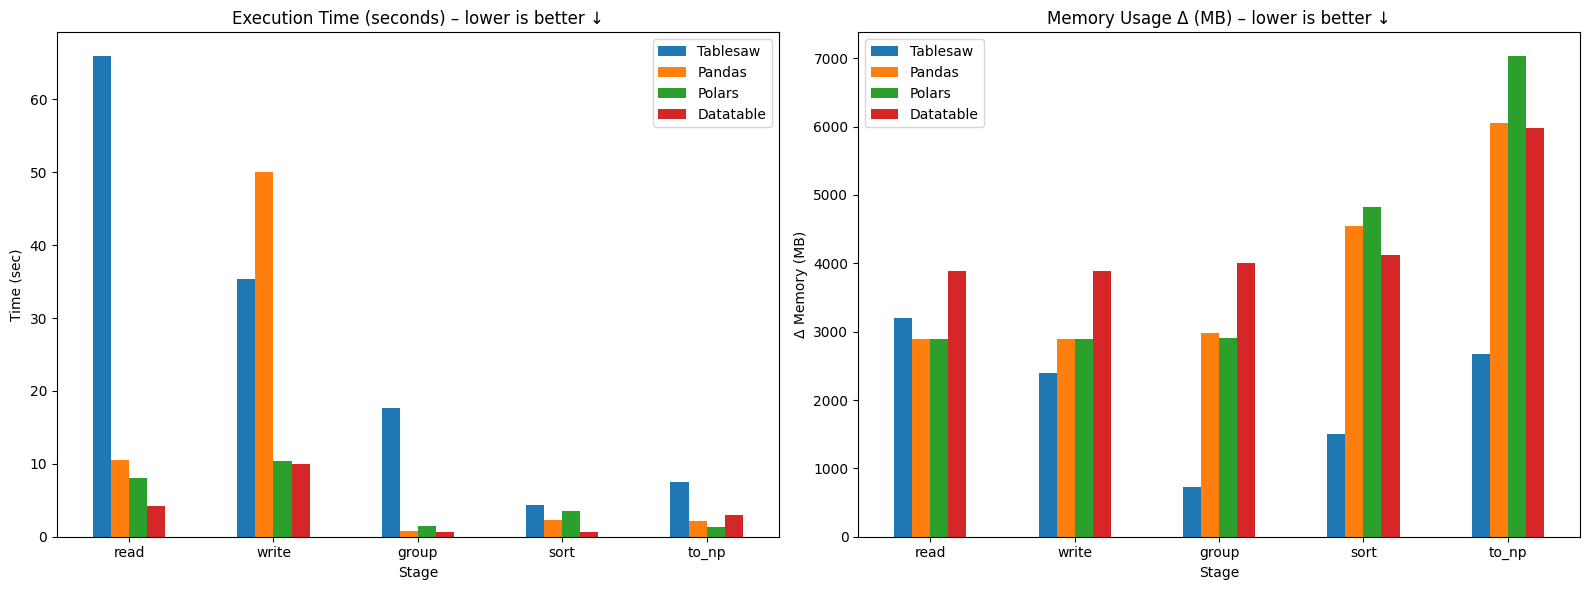

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

data_seconds = {
    "stage": ["read", "write", "group", "sort", "to_np"],
    "Tablesaw": [65.911, 35.350, 17.722, 4.419, 7.568],
    "Pandas":   [10.540, 50.006, 0.839, 2.232, 2.162],
    "Polars":   [8.057,  10.444, 1.411, 3.464, 1.354],
    "Datatable":[4.187,  10.004, 0.695, 0.705, 3.049],
}

data_memory = {
    "stage": ["read", "write", "group", "sort", "to_np"],
    "Tablesaw": [3202.0, 2398.0, 733.0, 1500.0, 2667.0],
    "Pandas":   [2896.6, 2896.5, 2974.4, 4549.2, 6046.0],
    "Polars":   [2899.5, 2899.5, 2903.7, 4817.5, 7027.5],
    "Datatable":[3894.0, 3894.2, 4009.8, 4125.4, 5974.8],
}

df_sec = pd.DataFrame(data_seconds)
df_mem = pd.DataFrame(data_memory)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

df_sec.set_index("stage").plot(kind="bar", ax=axes[0])
axes[0].set_title("Execution Time (seconds) – lower is better ↓")
axes[0].set_ylabel("Time (sec)")
axes[0].set_xlabel("Stage")
axes[0].tick_params(axis='x', rotation=0)

df_mem.set_index("stage").plot(kind="bar", ax=axes[1])
axes[1].set_title("Memory Usage Δ (MB) – lower is better ↓")
axes[1].set_ylabel("Δ Memory (MB)")
axes[1].set_xlabel("Stage")
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


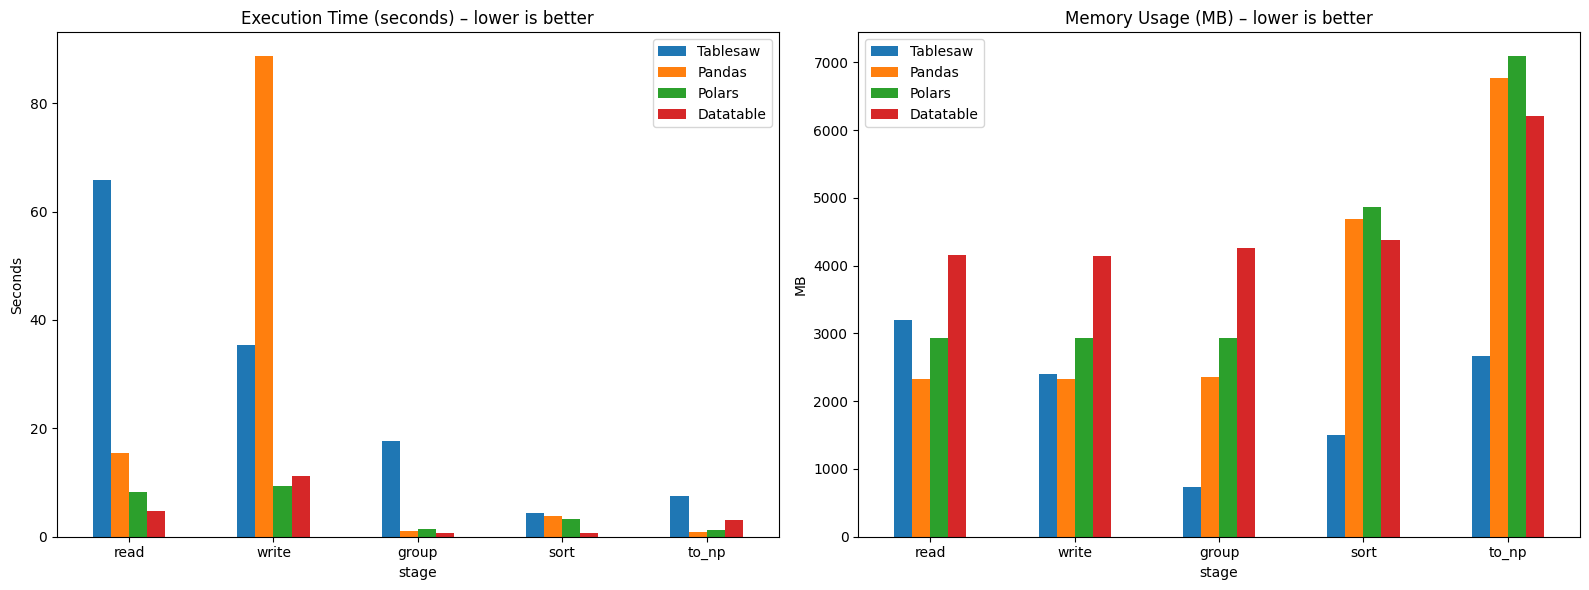

In [14]:
#New plot
import pandas as pd
import matplotlib.pyplot as plt

data_seconds = {
    "stage": ["read", "write", "group", "sort", "to_np"],
    "Tablesaw": [65.911, 35.350, 17.722, 4.419, 7.568],
    "Pandas":   [15.528, 88.642, 0.966, 3.882, 0.808],
    "Polars":   [8.262,  9.340,  1.445, 3.309, 1.153],
    "Datatable":[4.719, 11.232, 0.691, 0.688, 3.067],
}

data_memory = {
    "stage": ["read", "write", "group", "sort", "to_np"],
    "Tablesaw": [3202.0, 2398.0,  733.0, 1500.0, 2667.0],
    "Pandas":   [2332.4, 2332.4, 2352.2, 4692.8, 6773.2],
    "Polars":   [2938.4, 2938.4, 2938.8, 4865.1, 7086.5],
    "Datatable":[4160.2, 4139.2, 4254.7, 4370.3, 6201.2],
}

df_sec = pd.DataFrame(data_seconds)
df_mem = pd.DataFrame(data_memory)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

df_sec.set_index("stage").plot(kind="bar", ax=axes[0])
axes[0].set_title("Execution Time (seconds) – lower is better")
axes[0].set_ylabel("Seconds")
axes[0].tick_params(axis="x", rotation=0)

df_mem.set_index("stage").plot(kind="bar", ax=axes[1])
axes[1].set_title("Memory Usage (MB) – lower is better")
axes[1].set_ylabel("MB")
axes[1].tick_params(axis="x", rotation=0)

plt.tight_layout()
plt.show()
